# Chapter 5: Field data study Rockeskyller Kopf
# ME1 Inversions


<div class="alert alert-success">
    
This Notebook only reproduces the results of ``Sata/Rockeskyll/Res_ME1``. Visualization in Notebook 5.4.

In [1]:
# %% IMPORTS
import numpy             as np
import matplotlib.pyplot as plt
import pandas            as pd
import pygimli           as pg
import pygimli.meshtools as mt
import cmasher           as cmr
import functools
import warnings

from pygimli.viewer             import pv
from pygimli.physics            import ert
from scipy.interpolate          import griddata
from AZ_pygimli_3DTopo          import *
from PlotFunctions_Ch5          import *
from datetime                   import datetime
from JointEntropyClass          import JointEntropyInversion as JEI

warnings.filterwarnings("ignore")

### Parameters and names

In [2]:
fig_dir = 'C:/Users/azieg/Desktop/GIT_repositories/APG-MSc-Project-Ziegon/Figures/Ch-5/'
fn_dir  = 'C:/Users/azieg/Desktop/GIT_repositories/APG-MSc-Project-Ziegon/Data/Rockeskyll/'

fn_mesh = 'invmesh.bms'

fn_magnetic = 'Magnetic_data_corrected.csv'

fn_all = 'ert_data_rockes_all'

n_lines = 4 # number of lines
idx_list = [0, 2055, 4134, 5906, 7694] # for Pseudosection display

# PARAMETERS (based on Boxberg 2011)
F = 48487.4   # Median field intensity in nT

SEED = 420 # Random seed to ensure reproduceability

# Plotting
c_ert = 'gnuplot'
c_mag = cmr.tropical
lim_pseudos = [18,180]

### Importing Magnetic Data and Geometry

In [3]:
# %% READING DATA CSV-FILE
df = pd.read_csv(fn_dir+fn_magnetic, delimiter=',', decimal='.')
d_obs = df['F'].to_numpy()-F                                           # Total Field Anomaly numpy array
pnts = np.array([[df['X'][i], df['Y'][i], df['Z'][i]] for i in range(len(df))])

### Importing ERT Data

Text(0.5, 1.0, 'ERT Data')

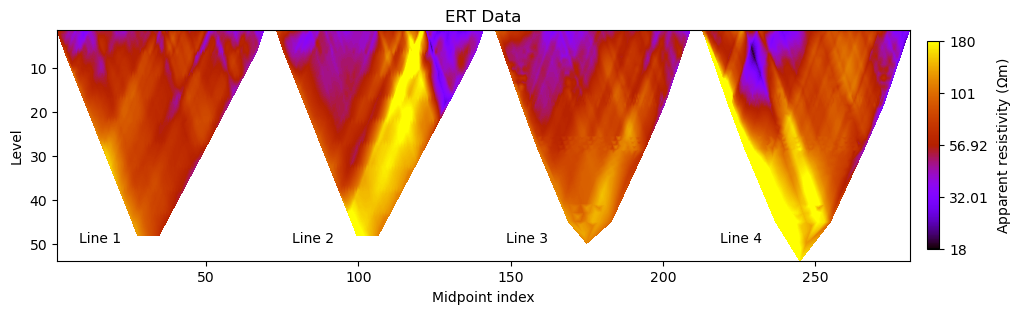

In [4]:
d_ert    = ert.load(fn_dir+fn_all)

# PLOT PSEUDOSECTIONS
%matplotlib inline
fig, ax = plt.subplots(figsize=(11,3))
showPseudosections(d_ert, d_ert['rhoa'].array(), idx_list, 4, ax=ax, clim=lim_pseudos, cmap=c_ert)
ax.set_title('ERT Data')

## Load Mesh

In [5]:
mesh = pg.load(fn_dir+fn_mesh)
mesh

Mesh: Nodes: 8381 Cells: 40005 Boundaries: 83717

### Magnetics 3D inversion

In [6]:
# Setup Inversion Manager
MAG, d_mag, relError = createMagManager(mesh, df)

   0%|          |0/294 [00:00 < ?]

In [12]:
# Create Starting model
startModel = pg.Vector(mesh.cellCount(), 1e-4) # surrounding rock has susceptibility of around 0.0001

In [13]:
# JEI Class Parameters
q = 1 
a = 50
lam = 0.05 
beta = 1e-10

# Fix seed   
np.random.seed(SEED)

# Initiate Class
Jm = JEI(mgr_list=[MAG], data_list=[d_mag], mesh=mesh, order=q, beta=beta, 
                               smooth_factor=a)
KWm = dict(lam=lam, startModel=startModel, verbose=True, err=relError, limits=[0, 0.15])
Jm.setKWInv([KWm])
Jm.setNames(['MAG'])

# Start Inversion
start_mag = datetime.now()
Jm.runInversion('ME', maxIter=50, chi_limit=1.5)
print(f'MAG Inversion took: {datetime.now()-start_mag}')

[sus] = Jm.getModels()

21/06/23 - 18:00:03 - pyGIMLi - INFO - Starting inversion.
21/06/23 - 18:00:03 - pyGIMLi - INFO - Setting starting model as reference!


Starting Iteration 0...
... MAG
fop: <pygimli.physics.gravimetry.MagneticsModelling.MagneticsModelling object at 0x00000235FD51AD10>
Data transformation: <pgcore._pygimli_.RTrans object at 0x00000235AEEFEA00>
Model transformation (cumulative):
	 0 <pgcore._pygimli_.RTransLogLU object at 0x00000235FE08D9A0>
min/max (data): -491/1454
min/max (error): 2.05%/7.53%
min/max (start model): 1.0e-04/1.0e-04
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
inv.iter 1 ... 

21/06/23 - 18:00:15 - pyGIMLi - INFO - Use median(data values)=355.6499999999978
21/06/23 - 18:00:15 - pyGIMLi - INFO - Created startmodel from forward operator: 40005 [355.6499999999978,...,355.6499999999978]


chi² = 1742.68 (dPhi = 6.33%) lam: 0.05
Starting iteration 1...
Set JME weights for MAG with q=1, b=1e-10 and a=50
#####     MAG weighted misfit chi^2   = 1386.21
#####     stabilizing functional    S = 4.09
#####     joint weighted misfit chi^2 = 1386.21
############################################################
       
Starting iteration 2...
Set JME weights for MAG with q=1, b=1e-10 and a=50
#####     MAG weighted misfit chi^2   = 1212.78
#####     stabilizing functional    S = 7.46
#####     joint weighted misfit chi^2 = 1212.78
############################################################
       
Starting iteration 3...
Set JME weights for MAG with q=1, b=1e-10 and a=50
#####     MAG weighted misfit chi^2   = 1069.02
#####     stabilizing functional    S = 11.07
#####     joint weighted misfit chi^2 = 1069.02
############################################################
       
Starting iteration 4...
Set JME weights for MAG with q=1, b=1e-10 and a=50
#####     MAG weighted misfit

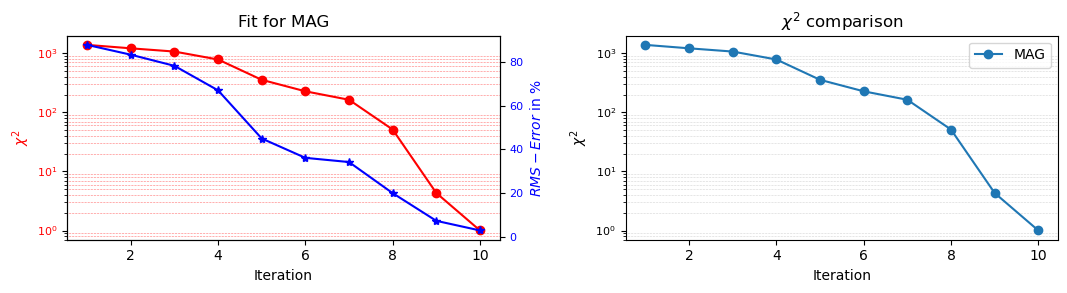

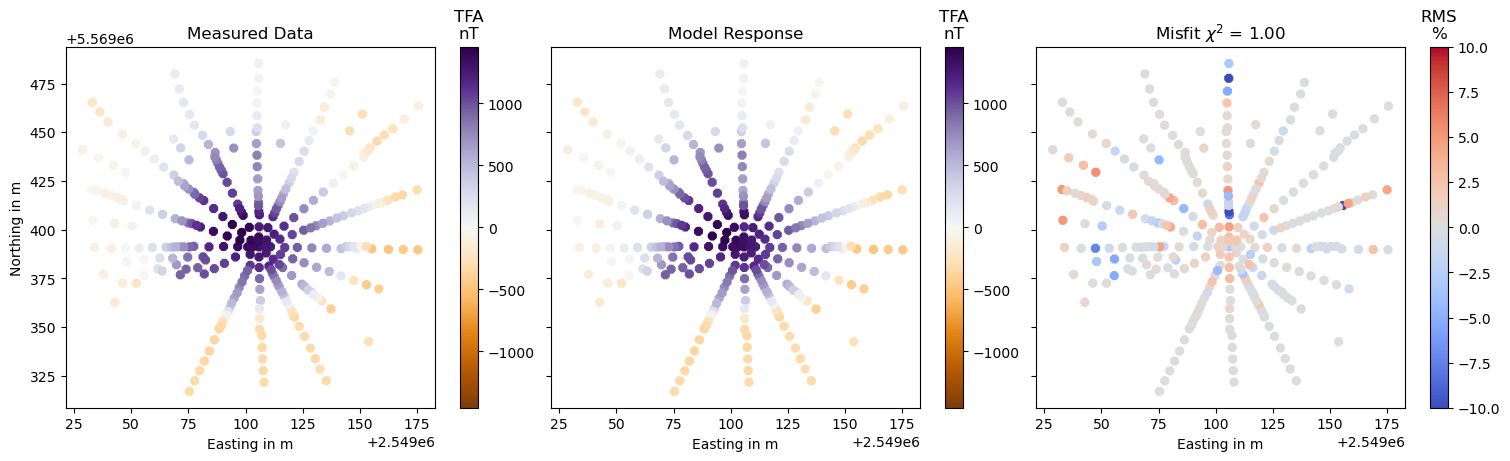

In [15]:
# Show result
%matplotlib inline
Jm.plotFitHistory()
plt.savefig(fig_dir+'ME1_MAG_fit.pdf', dpi=600, bbox_inches='tight')
fig, ax = showMagResult(pnts, MAG.inv)
plt.savefig(fig_dir+'ME1_MAG_overview.pdf', dpi=600, bbox_inches='tight')

# Get response and misfit and model
d_pre = np.array(MAG.inv.response,dtype=float) # Predicted data in numpy array
mag_misfit = 100*(d_obs-d_pre)/d_obs          # Misfit in %

# Save model and misfit
np.save(fn_dir+'Res_ME1/misfit_mag_me', mag_misfit)
np.save(fn_dir+'Res_ME1/sus_me', np.array(sus))

In [10]:
mesh['sus'] = sus
%matplotlib widget
pl, _ = pg.show(mesh, style="surface", cMap=c_mag, hold=True, notebook=False, alpha=0.2)
pv.drawMesh(pl, mesh, label="sus", style="surface", cMap=c_mag, alpha=0.7,
            filter={"threshold": dict(value=0.1, scalars="sus")})
pl.show()

### ERT 3D inversion

In [ ]:
q = 1 
a = 35
lam = 0.005 
beta = 1e-10

ERT = ert.ERTManager(d_ert)

Je = JEI(mgr_list=[ERT], data_list=[d_ert], mesh=mesh, order=q, beta=beta, smooth_factor=a)

KWe = dict(lam=lam, verbose=True, limits=[1, 5e4])
Je.setKWInv([KWe])
Je.setNames(['ERT'])

start_ert = datetime.now()
Je.runInversion('ME', maxIter=10, chi_limit=5.5)
print(f'ERT Inversion took: {datetime.now()-start_ert}')

[res] = Je.getModels()

16/06/23 - 15:37:06 - pyGIMLi - INFO - Found 1 regions.
16/06/23 - 15:37:06 - pyGIMLi - INFO - Creating forward mesh from region infos.


Starting Iteration 0...
... ERT


16/06/23 - 15:37:12 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/06/23 - 15:37:20 - pyGIMLi - INFO - Mesh for forward task: Mesh: Nodes: 60473 Cells: 320040 Boundaries: 334868
16/06/23 - 15:37:31 - pyGIMLi - INFO - Use median(data values)=67.41308595645845
16/06/23 - 15:37:31 - pyGIMLi - INFO - Created startmodel from forward operator: 40005 [67.41308595645845,...,67.41308595645845]
16/06/23 - 15:37:31 - pyGIMLi - INFO - Starting inversion.
16/06/23 - 15:37:31 - pyGIMLi - INFO - Setting starting model as reference!


fop: <pygimli.physics.ert.ertModelling.ERTModelling object at 0x000002006BCD9EF0>
Data transformation: <pgcore._pygimli_.RTransLogLU object at 0x000002006BBACD10>
Model transformation (cumulative):
	 0 <pgcore._pygimli_.RTransLogLU object at 0x0000020069E602E0>
min/max (data): 17.62/854
min/max (error): 3%/16.77%
min/max (start model): 67.41/67.41
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
inv.iter 1 ... chi² = 91.08 (dPhi = 37.66%) lam: 0.005
Starting iteration 1...
Set JME weights for ERT with q=1, b=1e-10 and a=25
#####     ERT weighted misfit chi^2   = 36.40
#####     stabilizing functional    S = 27285.69
#####     joint weighted misfit chi^2 = 36.40
############################################################
       
Starting iteration 2...
Set JME weights for ERT with q=1, b=1e-10 and a=25
#####     ERT weighted misfit chi^2   = 21.26
#####     stabilizing funct

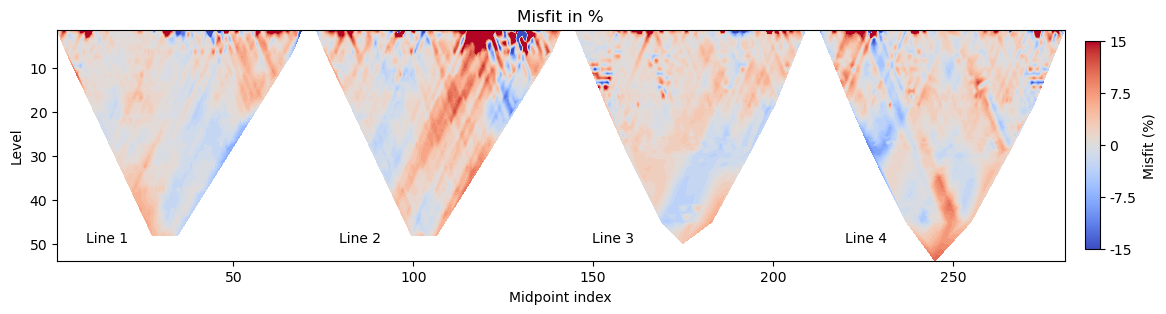

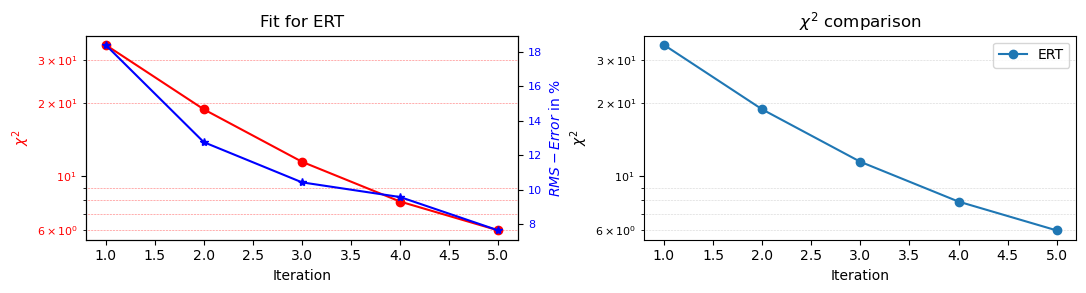

In [10]:
# Save in Model and mesh
np.save(fn_dir+'Res_ME1/res_me', ERT.model)

misfit_3d =  100*(d_ert['rhoa'].array()-ERT.inv.response.array())/d_ert['rhoa'].array()
np.save(fn_dir+'Res_ME1/misfit_ert_me', misfit_3d)

%matplotlib inline
fig, ax = plt.subplots(1,figsize=(13, 3))
showPseudosections(d_ert, misfit_3d, idx_list, 4, ax=ax, clim=[-15, 15], cmap='coolwarm', Type='misfit')
ax.set_title('Misfit in %')

Je.plotFitHistory()
plt.savefig(fig_dir+'ME1_ERT_fit.pdf', dpi=600, bbox_inches='tight')